In [160]:
import gc
import os, shutil
import numpy as np
import re
import chardet
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm_progress
import seaborn as sns 
from PIL import Image

import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras import layers

import tensorflow as tf 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras import models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, MaxPool2D
from tensorflow.keras.losses import BinaryCrossentropy

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, multilabel_confusion_matrix, precision_recall_curve, average_precision_score, precision_score, recall_score, f1_score


from imblearn.over_sampling import SMOTE



In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# Preprocessing Data

## Read Data 

### Detect Encoding

In [4]:
def detect_encoding_for_files(directory):
    encoding_results = {}
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):  # Check if the file is a text file.
            file_path = os.path.join(directory, filename)  # Get the full path of the file.
            encoding = detect_encoding(file_path)
            encoding_results[filename] = encoding
    return encoding_results

def detect_encoding(file_path):
    with open(file_path, 'rb') as file:
        raw_data = file.read()
        result = chardet.detect(raw_data)
        encoding = result['encoding']
    return encoding
    
# Example usage:
directory = r"C:\Users\david\DeepLearning\DataSets\Movie_Poster_Metadata\groundtruth"
encoding_results = detect_encoding_for_files(directory)
for filename, encoding in encoding_results.items():
    print(f"{filename}: {encoding}")

1980.txt: ascii
1981.txt: ascii
1982.txt: UTF-16
1983.txt: UTF-16
1984.txt: UTF-16
1985.txt: UTF-16
1986.txt: UTF-16
1987.txt: UTF-16
1988.txt: UTF-16
1989.txt: UTF-16
1990.txt: UTF-16
1991.txt: UTF-16
1992.txt: UTF-16
1993.txt: UTF-16
1994.txt: UTF-16
1995.txt: UTF-16
1996.txt: UTF-16
1997.txt: UTF-16
1998.txt: UTF-16
1999.txt: UTF-16
2000.txt: UTF-16
2001.txt: UTF-16
2002.txt: UTF-16
2003.txt: UTF-16
2004.txt: UTF-16
2005.txt: UTF-16
2006.txt: UTF-16
2007.txt: UTF-16
2008.txt: UTF-16
2009.txt: UTF-16
2010.txt: UTF-16
2011.txt: UTF-16
2012.txt: UTF-16
2013.txt: UTF-16
2014.txt: UTF-16
2015.txt: UTF-16


### Read txt files

In [5]:
#Checks the encoding and writes all files to a big string 
def read_text_files(directory):
    file_string = ""  # Initialize an empty string to hold all the text.
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):  # Check if the file is a text file.
            file_path = os.path.join(directory, filename)  # Get the full path of the file.
            
            # Detect encoding of the file
            encoding = detect_encoding(file_path)
            
            # Read the file using the detected encoding
            with open(file_path, 'r', encoding=encoding) as file:
                # Read the file and append its content to the big string
                file_content = file.read()
                file_string += file_content + "\n"
    return file_string


def convert_to_json(string):
    # Split the big string into individual objects
    objects = string.split("}\n{")
    # Join the objects with a comma and newline, and maintain curly braces
    json_string = "},\n{".join(objects)
    # Enclose the whole string with square brackets to make it a valid JSON array
    json_string = f"[{json_string}]"
    return json_string

def fix_json(json_string):
    # Define regex patterns for replacing
    patterns = {
        r'ObjectId\("(.*?)"\)': r'"\1"',  # Matches ObjectId() and replaces it with just the string inside the parenthesis
        r'"h"ttp"(.*)"': r'"http\1"',  # Matches "h"ttp" and replaces it with "http"
        r'"(.*?)" : "(.*?)"(.*?)"(.*?)"':'"\1" : "\2\3\4"',  # Matches "Some Header" : "Some "Value" "..." " and replaces it with "Some header" : "Some Value"
        r'[਍ഀ]':'' # replaces all invalid characters with empty string 
    }

    # Apply regex replacements
    for pattern, replacement in patterns.items():
        json_string = re.sub(pattern, replacement, json_string)

    return json_string


def write_json_to_file(json_string, filename, encoding='utf-16'):
    with open(filename, 'w', encoding=encoding) as file:
        file.write(json_string)



In [269]:
file_string = read_text_files(directory)
print(file_string[:835])

{
  "_id" : ObjectId("56fb860e71a0651b0c306f55"),
  "Language" : "English",
  "Box_office" : "290,158,751",
  "Country" : "USA",
  "Rated" : "PG",
  "imdbID" : "tt0080684",
  "Awards" : "Won 1 Oscar. Another 15 wins & 18 nominations.",
  "Poster" : "h"ttp"://ia.media-imdb.com/images/M/MV5BMjE2MzQwMTgxN15BMl5BanBnXkFtZTcwMDQzNjk2OQ@@._V1_SX300.jpg",
  "Director" : "Irvin Kershner",
  "Released" : "20 Jun 1980",
  "Writer" : "Leigh Brackett (screenplay), Lawrence Kasdan (screenplay), George Lucas (story)",
  "imdbVotes" : "799,579",
  "Runtime" : "124 min",
  "Response" : "True",
  "imdbRating" : "8.8",
  "Title" : "Star "Wars": Episode V - The Empire Strikes Back",
  "Genre" : "Action, Adventure, Fantasy",
  "Actors" : "Mark Hamill, Harrison Ford, Carrie Fisher, Billy Dee Williams",
  "Type" : "movie",
  "Metascore" : "79"
}


### Convert to Json 
regex was used to find and replace specific strings to make them eligible to be in json format

In [270]:
fixed_format = fix_json(file_string)
json_string = convert_to_json(fixed_format)

#Verifying the },{ format 
json_string = json_string.replace("}\n\n{", "},\n\n{")
# Next, replace the single newline sequence
json_string =  json_string.replace("}\n{", "},\n{")

fileName = r'C:\Users\david\DeepLearning\DataSets\Movie_Poster_Metadata\txt_to_json\txt_json.txt'
write_json_to_file(json_string,fileName )

print(detect_encoding(fileName))



UTF-16


### Convert to CSV

In [8]:
# Parse JSON data string
json_data = json.loads(json_string)

# Specify CSV file path
csv_file_path = r'C:\Users\david\DeepLearning\DataSets\Movie_Poster_Metadata\groundtruth_as_csv\data.csv'

# Extract fieldnames dynamically from JSON data
fieldnames = list(json_data[0].keys())

# Write data to CSV file
with open(csv_file_path, 'w', newline='') as csvfile:
    # Define CSV writer
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    # Write header
    writer.writeheader()
    
    # Write rows
    for row in json_data:
        # Filter out keys not in fieldnames and handle missing keys
        filtered_row = {key: row.get(key, '') for key in fieldnames}
        writer.writerow(filtered_row)


## Analyse Data

In [9]:
csv_data = r'C:\Users\david\DeepLearning\DataSets\Movie_Poster_Metadata\groundtruth_as_csv\data.csv'

# Read CSV file into DataFrame
df = pd.read_csv(csv_data, encoding='latin-1')

# Display the DataFrame
print(df)

                           _id Language   Box_office    Country    Rated  \
0     56fb860e71a0651b0c306f55  English  290,158,751        USA       PG   
1     56fb860e71a0651b0c306f56  English  101,500,000        USA        R   
2     56fb860e71a0651b0c306f57  English   83,400,000        USA       PG   
3     56fb860e71a0651b0c306f58  English          NaN        USA       PG   
4     56fb860e71a0651b0c306f59  English   69,800,000        USA        R   
...                        ...      ...          ...        ...      ...   
8868  570780c771a0650b20736c69  English        1,711        USA      NaN   
8869  570780c771a0650b20736c6a  English        1,631  Australia  UNRATED   
8870  570780c771a0650b20736c6b  English        1,056        USA      NaN   
8871  570780c771a0650b20736c6c  English          NaN        USA      NaN   
8872  570780c771a0650b20736c6d  Spanish          NaN      Spain      NaN   

         imdbID                                             Awards  \
0     tt0080684  

In [10]:
column_names = df.columns
print(column_names)


Index(['_id', 'Language', 'Box_office', 'Country', 'Rated', 'imdbID', 'Awards',
       'Poster', 'Director', 'Released', 'Writer', 'imdbVotes', 'Runtime',
       'Response', 'imdbRating', 'Unnamed: 15', 'Genre', 'Actors', 'Type',
       'Metascore'],
      dtype='object')


IMDBID and the jpeg file name is the same for every poster 

In [11]:
df_genres = df[["imdbID","Genre"]]

print(df_genres)

         imdbID                       Genre
0     tt0080684  Action, Adventure, Fantasy
1     tt0081562               Comedy, Crime
2     tt0080339                      Comedy
3     tt0080377              Action, Comedy
4     tt0081375                 Comedy, War
...         ...                         ...
8868  tt2912776                Drama, Music
8869  tt2241750                Drama, Sport
8870  tt4797082                 Documentary
8871  tt5350540          Documentary, Short
8872  tt4529904                      Comedy

[8873 rows x 2 columns]


In [12]:
jpeg_dir = r'C:\Users\david\DeepLearning\DataSets\Movie_Poster_Dataset\Movie_Poster_Dataset'

def extract_jpeg_data(jpeg_dir):
    jpeg_data = []
    for dirpath, _, filenames in os.walk(jpeg_dir):
        for filename in filenames:
            # Check if file is a JPEG file
            if filename.lower().endswith('.jpg') or filename.lower().endswith('.jpeg'):
                # Extract IMDb number from file name
                imdb_number = os.path.splitext(filename)[0]
                file_path = os.path.join(dirpath, filename)
                # Read JPEG file and store IMDb number and image data
                with open(os.path.join(dirpath, filename), 'rb') as file:
                    image_data = file.read()
                jpeg_data.append({'Title': imdb_number, 'PosterPath': file_path,'ImageData': image_data})
    return jpeg_data
    
# Extract JPEG data recursively from root directory
jpeg_data = extract_jpeg_data(jpeg_dir)

# Create DataFrame from JPEG data
df_jpeg = pd.DataFrame(jpeg_data)

df_merged = pd.merge(df_genres, df_jpeg, left_on='imdbID', right_on='Title', how='left')


print(df_merged[['Title','Genre','PosterPath']])



          Title                       Genre  \
0     tt0080684  Action, Adventure, Fantasy   
1     tt0081562               Comedy, Crime   
2     tt0080339                      Comedy   
3     tt0080377              Action, Comedy   
4     tt0081375                 Comedy, War   
...         ...                         ...   
8868  tt2912776                Drama, Music   
8869  tt2241750                Drama, Sport   
8870        NaN                 Documentary   
8871        NaN          Documentary, Short   
8872        NaN                      Comedy   

                                             PosterPath  
0     C:\Users\david\DeepLearning\DataSets\Movie_Pos...  
1     C:\Users\david\DeepLearning\DataSets\Movie_Pos...  
2     C:\Users\david\DeepLearning\DataSets\Movie_Pos...  
3     C:\Users\david\DeepLearning\DataSets\Movie_Pos...  
4     C:\Users\david\DeepLearning\DataSets\Movie_Pos...  
...                                                 ...  
8868  C:\Users\david\DeepLear

In [13]:
# Create DataFrame from JPEG data
df_jpeg = pd.DataFrame(jpeg_data)

df_merged = pd.merge(df_genres, df_jpeg, left_on='imdbID', right_on='Title', how='left')


print(df_merged[['Title','Genre','PosterPath']])

          Title                       Genre  \
0     tt0080684  Action, Adventure, Fantasy   
1     tt0081562               Comedy, Crime   
2     tt0080339                      Comedy   
3     tt0080377              Action, Comedy   
4     tt0081375                 Comedy, War   
...         ...                         ...   
8868  tt2912776                Drama, Music   
8869  tt2241750                Drama, Sport   
8870        NaN                 Documentary   
8871        NaN          Documentary, Short   
8872        NaN                      Comedy   

                                             PosterPath  
0     C:\Users\david\DeepLearning\DataSets\Movie_Pos...  
1     C:\Users\david\DeepLearning\DataSets\Movie_Pos...  
2     C:\Users\david\DeepLearning\DataSets\Movie_Pos...  
3     C:\Users\david\DeepLearning\DataSets\Movie_Pos...  
4     C:\Users\david\DeepLearning\DataSets\Movie_Pos...  
...                                                 ...  
8868  C:\Users\david\DeepLear

In [14]:
df_merged = df_merged.dropna()[['Title','Genre','PosterPath']]
df_merged['Genres'] = df_merged['Genre'].str.split(',')
print(df_merged)


          Title                       Genre  \
0     tt0080684  Action, Adventure, Fantasy   
1     tt0081562               Comedy, Crime   
2     tt0080339                      Comedy   
3     tt0080377              Action, Comedy   
4     tt0081375                 Comedy, War   
...         ...                         ...   
8864  tt4159182                    Thriller   
8865  tt2265431      Comedy, Drama, Romance   
8866  tt3240784                 Documentary   
8868  tt2912776                Drama, Music   
8869  tt2241750                Drama, Sport   

                                             PosterPath  \
0     C:\Users\david\DeepLearning\DataSets\Movie_Pos...   
1     C:\Users\david\DeepLearning\DataSets\Movie_Pos...   
2     C:\Users\david\DeepLearning\DataSets\Movie_Pos...   
3     C:\Users\david\DeepLearning\DataSets\Movie_Pos...   
4     C:\Users\david\DeepLearning\DataSets\Movie_Pos...   
...                                                 ...   
8864  C:\Users\david\D

In [15]:
# Create a list of all genres and clean up the genre names
all_genres = [genre.lower().strip() for sublist in df_merged['Genres'] for genre in sublist]

# Get unique genres
unique_genres = set(all_genres)

# Count occurrences of each genre
genre_counts = pd.Series(all_genres).value_counts()

# Display count for each genre
print("Count for each genre:")
print(genre_counts)
print(unique_genres)
print(genre_counts.describe())

Count for each genre:
drama          4000
comedy         3206
action         1477
romance        1457
crime          1280
thriller       1015
adventure       978
documentary     739
horror          569
mystery         506
biography       505
fantasy         502
family          476
sci-fi          442
music           346
animation       272
history         261
sport           251
war             158
musical         113
western          57
short            57
news             26
reality-tv        2
dtype: int64
{'action', 'documentary', 'fantasy', 'reality-tv', 'short', 'drama', 'crime', 'comedy', 'romance', 'western', 'music', 'horror', 'history', 'animation', 'thriller', 'sci-fi', 'biography', 'mystery', 'family', 'war', 'adventure', 'news', 'musical', 'sport'}
count      24.000000
mean      778.958333
std       979.572155
min         2.000000
25%       227.750000
50%       489.000000
75%       987.250000
max      4000.000000
dtype: float64


In [16]:
# Genres to exclude
genres_to_exclude = {'music', 'animation', 'history', 'sport', 'war', 'musical', 'western', 'short', 'news', 'reality-tv'}  # These are genres with less than 500 entries
# Function to clean genres and check for exclusion
def clean_and_check_genres(genre_list):
    cleaned_list = [genre.strip().lower() for genre in genre_list]
    return not any(genre in genres_to_exclude for genre in cleaned_list)

# Apply cleaning and checking function
df_filtered = df_merged[df_merged['Genres'].apply(clean_and_check_genres)]

all_filtered_genres = [genre.lower().strip() for sublist in df_filtered['Genres'] for genre in sublist]

# Display the updated DataFrame
print(set(all_filtered_genres))

# Prepare for encoding
# Ensure the 'Genres' are cleaned lists not just strings
df_filtered['Genres'] = df_filtered['Genres'].apply(lambda x: [genre.strip().lower() for genre in x if genre.strip().lower() not in genres_to_exclude])

# Get the count of each genre
genre_counts = pd.Series(all_filtered_genres).value_counts()

# Display the descriptive statistics for these counts
print(genre_counts)
print(genre_counts.describe())


{'horror', 'crime', 'mystery', 'action', 'documentary', 'fantasy', 'family', 'drama', 'thriller', 'sci-fi', 'biography', 'comedy', 'romance', 'adventure'}
drama          3275
comedy         2793
action         1348
romance        1290
crime          1238
thriller        984
adventure       758
horror          558
mystery         499
documentary     489
fantasy         465
sci-fi          426
family          358
biography       303
dtype: int64
count      14.000000
mean     1056.000000
std       915.188001
min       303.000000
25%       471.000000
50%       658.000000
75%      1277.000000
max      3275.000000
dtype: float64


C:\Users\david\AppData\Local\Temp\ipykernel_28312\3054581075.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Genres'] = df_filtered['Genres'].apply(lambda x: [genre.strip().lower() for genre in x if genre.strip().lower() not in genres_to_exclude])


## Prepare for Training

In [17]:
# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

Y = mlb.fit_transform(df_filtered['Genres'])

# Get the list of unique genres
unique_genres = mlb.classes_

print("Shape of Encoded Labels:", Y.shape)
print(unique_genres)

# Iterate over the columns and check where the value is 1
def get_corresponding_genres(poster_index):
    corresponding_genres = [unique_genres[i] for i, value in enumerate(Y[poster_index]) if value == 1]
    return corresponding_genres

# Print the corresponding genres
print("Genres for the poster:")
print(get_corresponding_genres(0))

# Print the corresponding genres
print("Encoding:")
print(Y[0])

Shape of Encoded Labels: (6587, 14)
['action' 'adventure' 'biography' 'comedy' 'crime' 'documentary' 'drama'
 'family' 'fantasy' 'horror' 'mystery' 'romance' 'sci-fi' 'thriller']
Genres for the poster:
['action', 'adventure', 'fantasy']
Encoding:
[1 1 0 0 0 0 0 0 1 0 0 0 0 0]


In [18]:
# Define the target size for resizing the images
img_width = 112
img_height = 112

# Directory containing folders with posters
data_dir = r"C:\Users\david\DeepLearning\DataSets\Movie_Poster_Dataset\Movie_Poster_Dataset"

# Initialize an empty list to store preprocessed images
X = []

# Walk over all folders and subfolders in the directory
for index, row in tqdm_progress(df_filtered.iterrows(), desc="Processing posters", total=len(df_filtered)):
    # Get the poster path from the DataFrame
    img_path = row['PosterPath']
    
    # Load the image and resize it to the target size
    img = image.load_img(img_path, target_size=(img_width, img_height))
    
    # Convert the image to a NumPy array
    img_array = image.img_to_array(img)
    
    # Normalize the pixel values to the range [0, 1]
    img_array /= 255.0
    
    # Append the preprocessed image to the list
    X.append(img_array)

# Convert the list of images to a NumPy array
X = np.stack(X, axis=0)

Processing posters: 100%|█████████████████████████████████████████████████████████| 6587/6587 [00:08<00:00, 771.05it/s]


In [19]:
X.shape

(6587, 112, 112, 3)

[0 0 0 0 1 0 1 0 0 0 1 0 0 0]
['crime', 'drama', 'mystery']


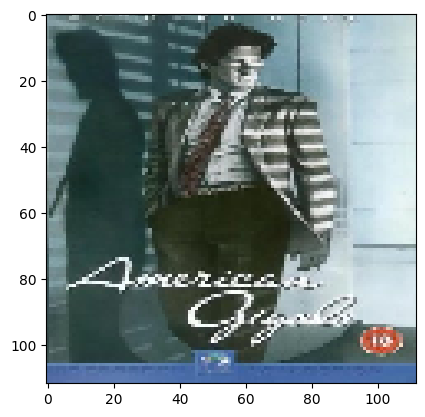

In [20]:
poster_index = 18
plt.imshow(X[poster_index])
print(Y[poster_index])
print(get_corresponding_genres(poster_index))

In [21]:
##Split into train and temporary sets with shuffling
X_train,X_split,y_train,y_split,posterPath_train_set,posterPath_temp_set = train_test_split(X,Y,df_filtered['PosterPath'],test_size=.2,shuffle=True,random_state=42)
##Split the temporary set into validation and test sets 
X_val,X_test,y_val,y_test= train_test_split(X_split,y_split,test_size=.50,shuffle=True,random_state=42)

# Display the shapes of the training and testing sets
print("Training set - Predictor variables:", X_train.shape)
print("Training set - Target variable:", y_train.shape)
print("Testing set - Predictor variables:", X_test.shape)
print("Testing set - Target variable:", y_test.shape)
print("Validation set - Predictor variables:", X_val.shape)
print("Validation set - Target variable:", y_val.shape)


Training set - Predictor variables: (5269, 112, 112, 3)
Training set - Target variable: (5269, 14)
Testing set - Predictor variables: (659, 112, 112, 3)
Testing set - Target variable: (659, 14)
Validation set - Predictor variables: (659, 112, 112, 3)
Validation set - Target variable: (659, 14)


In [22]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(
    X_train, y_train,
    batch_size=32
)

print("Training data shape:", X_train.shape)
print("Labels shape:", y_train.shape)

Training data shape: (5269, 112, 112, 3)
Labels shape: (5269, 14)


# Train Models

In [23]:
model = Sequential()

#First convolutional layer. Has input size set. 
model.add(Conv2D(128,kernel_size= (3,3),activation = 'relu', input_shape=(img_width,img_height,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(.2))

model.add(Conv2D(128,kernel_size= (3,3),activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(.33))

model.add(Conv2D(64,kernel_size= (3,3),activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(.33))


model.add(Conv2D(64,kernel_size= (3,3),activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(.33))

model.add(Conv2D(32,kernel_size= (3,3),activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(.33))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(.33))
 
#3Flatten and begin dense layers 
model.add(Flatten())
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(.15))

model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(.33))

#Output layer
model.add(Dense(14,activation = 'sigmoid'))##14 for the output genres, and sigmoid for the multilabel aspect


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 110, 128)     3584      
                                                                 
 batch_normalization (BatchN  (None, 110, 110, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 55, 55, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 53, 53, 128)       147584    
                                                                 
 batch_normalization_1 (Batc  (None, 53, 53, 128)      5

In [25]:
model_aug = Sequential()

#First convolutional layer. Has input size set. 
model_aug.add(Conv2D(128,kernel_size= (3,3),activation = 'relu', input_shape=(img_width,img_height,3)))
model_aug.add(BatchNormalization())
model_aug.add(MaxPooling2D(pool_size=(2,2)))
model_aug.add(Dropout(.2))

model_aug.add(Conv2D(128,kernel_size= (3,3),activation = 'relu'))
model_aug.add(BatchNormalization())
model_aug.add(Dropout(.33))

model_aug.add(Conv2D(64,kernel_size= (3,3),activation = 'relu'))
model_aug.add(BatchNormalization())
model_aug.add(Dropout(.33))


model_aug.add(Conv2D(64,kernel_size= (3,3),activation = 'relu'))
model_aug.add(BatchNormalization())
model_aug.add(MaxPooling2D(pool_size=(2,2)))
model_aug.add(Dropout(.33))

model_aug.add(Conv2D(32,kernel_size= (3,3),activation = 'relu'))
model_aug.add(BatchNormalization())
model_aug.add(MaxPooling2D(pool_size=(2,2)))
model_aug.add(Dropout(.33))

model_aug.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model_aug.add(BatchNormalization())
model_aug.add(MaxPooling2D(pool_size=(2,2)))
model_aug.add(Dropout(.33))
 
#3Flatten and begin dense layers 
model_aug.add(Flatten())
model_aug.add(Dense(256,activation = 'relu'))
model_aug.add(BatchNormalization())
model_aug.add(Dropout(.15))

model_aug.add(Dense(128, activation = 'relu'))
model_aug.add(BatchNormalization())
model_aug.add(Dropout(.33))

#Output layer
model_aug.add(Dense(14,activation = 'sigmoid'))##14 for the output genres, and sigmoid for the multilabel aspect


In [26]:
print("Input shape expected by the model:", model.input_shape)
print("Actual input shape in training set:", X_train.shape)
print("Actual input shape in validation set:", X_val.shape)
print("Output units:", model.output_shape)
print("Label shape in training set:", y_train.shape)
print("Label shape in validation set:", y_val.shape)

Input shape expected by the model: (None, 112, 112, 3)
Actual input shape in training set: (5269, 112, 112, 3)
Actual input shape in validation set: (659, 112, 112, 3)
Output units: (None, 14)
Label shape in training set: (5269, 14)
Label shape in validation set: (659, 14)


In [27]:
##Compile the model 
model.compile(optimizer= keras.optimizers.Adam(learning_rate=.0001),
              loss=BinaryCrossentropy(),
              metrics=['binary_accuracy'])

In [28]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

for layer in vgg_model.layers:
    layer.trainable = False
    print(layer.name)


input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [29]:
vgg_model.get_layer('block5_conv3').trainable = True

model_vgg = Sequential() 
model_vgg.add(vgg_model)
model_vgg.add(Flatten())
model_vgg.add(Dense(14,activation='sigmoid'))##Add dense layer with the output needed for this problem

In [30]:
# Flatten the output of the convolutional base
x = Flatten()(vgg_model.output)

# Add a fully connected layer
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization

# Add another dense layer
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Final output layer with softmax activation for classification
num_classes = 14  # Change this number based on your specific scenario
output = Dense(num_classes, activation='softmax')(x)

# Create the full model
model_vgg = Model(inputs=vgg_model.input, outputs=output)

In [31]:
vgg_model_aug = VGG16(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

for layer in vgg_model_aug.layers:
    layer.trainable = False
    print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [32]:
vgg_model_aug.get_layer('block5_conv3').trainable = True

model_vgg_aug = Sequential() 
model_vgg_aug.add(vgg_model_aug)
model_vgg_aug.add(Flatten())
model_vgg_aug.add(Dense(14,activation='sigmoid'))##Add dense layer with the output needed for this problem

In [33]:
# Flatten the output of the convolutional base
x = Flatten()(vgg_model_aug.output)

# Add a fully connected layer
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization

# Add another dense layer
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Final output layer with softmax activation for classification
num_classes = 14  # Change this number based on your specific scenario
output = Dense(num_classes, activation='softmax')(x)

# Create the full model
model_vgg = Model(inputs=vgg_model_aug.input, outputs=output)

In [35]:
## fit the model 
callback = EarlyStopping(monitor = 'val_loss', patience = 10)
# Create a ModelCheckpoint callback
checkpoint_cnn = ModelCheckpoint("best_model_cnn.h5", save_best_only=True, monitor='val_loss')

gc.collect()

train_cnn = model.fit(X_train,y_train, epochs =30,verbose =1,validation_data=(X_val,y_val), callbacks=[callback,checkpoint_cnn])

Epoch 1/30
165/165 [==============================] - 65s 112ms/step - loss: 0.9090 - binary_accuracy: 0.5147 - val_loss: 0.7459 - val_binary_accuracy: 0.5034
Epoch 2/30
165/165 [==============================] - 16s 100ms/step - loss: 0.8426 - binary_accuracy: 0.5359 - val_loss: 1.0810 - val_binary_accuracy: 0.3635
Epoch 3/30
165/165 [==============================] - 16s 99ms/step - loss: 0.7893 - binary_accuracy: 0.5593 - val_loss: 1.2708 - val_binary_accuracy: 0.3324
Epoch 4/30
165/165 [==============================] - 16s 100ms/step - loss: 0.7428 - binary_accuracy: 0.5814 - val_loss: 1.0555 - val_binary_accuracy: 0.3837
Epoch 5/30
165/165 [==============================] - 16s 100ms/step - loss: 0.6962 - binary_accuracy: 0.6081 - val_loss: 0.8336 - val_binary_accuracy: 0.4537
Epoch 6/30
165/165 [==============================] - 16s 99ms/step - loss: 0.6533 - binary_accuracy: 0.6461 - val_loss: 0.8877 - val_binary_accuracy: 0.4423
Epoch 7/30
165/165 [============================

In [36]:
model_vgg.compile(optimizers.Adam(learning_rate=.0001), loss='binary_crossentropy', metrics=['binary_accuracy'])

In [37]:
vgg_checkpoint = ModelCheckpoint('best_vgg.h5',monitor = 'val_loss',save_best_only = True)
vgg_checkpoint2 = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights=True)
vgg_callbacks = [vgg_checkpoint,vgg_checkpoint2]
history_vgg = model_vgg.fit(X_train,y_train, epochs=30, validation_data=(X_val,y_val), callbacks=vgg_callbacks)

Epoch 1/30
165/165 [==============================] - 13s 64ms/step - loss: 0.4730 - binary_accuracy: 0.8403 - val_loss: 0.3845 - val_binary_accuracy: 0.8406
Epoch 2/30
165/165 [==============================] - 8s 47ms/step - loss: 0.4211 - binary_accuracy: 0.8450 - val_loss: 0.3745 - val_binary_accuracy: 0.8420
Epoch 3/30
165/165 [==============================] - 8s 47ms/step - loss: 0.3990 - binary_accuracy: 0.8475 - val_loss: 0.3660 - val_binary_accuracy: 0.8474
Epoch 4/30
165/165 [==============================] - 8s 47ms/step - loss: 0.3864 - binary_accuracy: 0.8479 - val_loss: 0.3612 - val_binary_accuracy: 0.8458
Epoch 5/30
165/165 [==============================] - 8s 47ms/step - loss: 0.3752 - binary_accuracy: 0.8509 - val_loss: 0.3597 - val_binary_accuracy: 0.8458
Epoch 6/30
165/165 [==============================] - 8s 47ms/step - loss: 0.3672 - binary_accuracy: 0.8529 - val_loss: 0.3575 - val_binary_accuracy: 0.8490
Epoch 7/30
165/165 [==============================] - 8s 

In [38]:
##Compile the model 
model_aug.compile(optimizer= keras.optimizers.Adam(learning_rate=.0001),
              loss=BinaryCrossentropy(),
              metrics=['binary_accuracy'])

In [40]:
## fit the model 
callback = EarlyStopping(monitor = 'val_loss', patience = 10)
# Create a ModelCheckpoint callback
checkpoint_aug = ModelCheckpoint("best_model_1_aug.h5", save_best_only=True, monitor='val_loss')

gc.collect()

train_aug = model_aug.fit(train_generator, epochs =30,verbose =1,validation_data=(X_val,y_val), callbacks=[callback,checkpoint_aug])

Epoch 1/30
165/165 [==============================] - 18s 101ms/step - loss: 0.9177 - binary_accuracy: 0.5136 - val_loss: 0.8191 - val_binary_accuracy: 0.4392
Epoch 2/30
165/165 [==============================] - 16s 96ms/step - loss: 0.8538 - binary_accuracy: 0.5328 - val_loss: 0.9837 - val_binary_accuracy: 0.5053
Epoch 3/30
165/165 [==============================] - 16s 96ms/step - loss: 0.7912 - binary_accuracy: 0.5558 - val_loss: 0.8843 - val_binary_accuracy: 0.4701
Epoch 4/30
165/165 [==============================] - 16s 96ms/step - loss: 0.7446 - binary_accuracy: 0.5771 - val_loss: 0.7100 - val_binary_accuracy: 0.5557
Epoch 5/30
165/165 [==============================] - 16s 97ms/step - loss: 0.6976 - binary_accuracy: 0.6074 - val_loss: 0.6074 - val_binary_accuracy: 0.6868
Epoch 6/30
165/165 [==============================] - 16s 96ms/step - loss: 0.6518 - binary_accuracy: 0.6432 - val_loss: 0.5618 - val_binary_accuracy: 0.7700
Epoch 7/30
165/165 [==============================]

In [41]:
model_vgg_aug.compile(optimizers.Adam(learning_rate=.0001), loss='binary_crossentropy', metrics=['binary_accuracy'])

In [42]:
vgg_aug_checkpoint = ModelCheckpoint('best_vgg_aug.h5',monitor = 'val_loss',save_best_only = True)
vgg_aug_checkpoint2 = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights=True)
vgg_aug_callbacks = [vgg_aug_checkpoint,vgg_aug_checkpoint2]
history_aug_vgg = model_vgg_aug.fit(train_generator, epochs=30, validation_data=(X_val,y_val), callbacks=vgg_aug_callbacks)

Epoch 1/30
165/165 [==============================] - 13s 74ms/step - loss: 0.3790 - binary_accuracy: 0.8484 - val_loss: 0.3648 - val_binary_accuracy: 0.8513
Epoch 2/30
165/165 [==============================] - 12s 73ms/step - loss: 0.3495 - binary_accuracy: 0.8582 - val_loss: 0.3584 - val_binary_accuracy: 0.8539
Epoch 3/30
165/165 [==============================] - 10s 62ms/step - loss: 0.3425 - binary_accuracy: 0.8617 - val_loss: 0.3595 - val_binary_accuracy: 0.8532
Epoch 4/30
165/165 [==============================] - 10s 63ms/step - loss: 0.3378 - binary_accuracy: 0.8623 - val_loss: 0.3531 - val_binary_accuracy: 0.8563
Epoch 5/30
165/165 [==============================] - 10s 62ms/step - loss: 0.3334 - binary_accuracy: 0.8641 - val_loss: 0.3520 - val_binary_accuracy: 0.8548
Epoch 6/30
165/165 [==============================] - 10s 61ms/step - loss: 0.3305 - binary_accuracy: 0.8632 - val_loss: 0.3572 - val_binary_accuracy: 0.8560
Epoch 7/30
165/165 [==============================] 

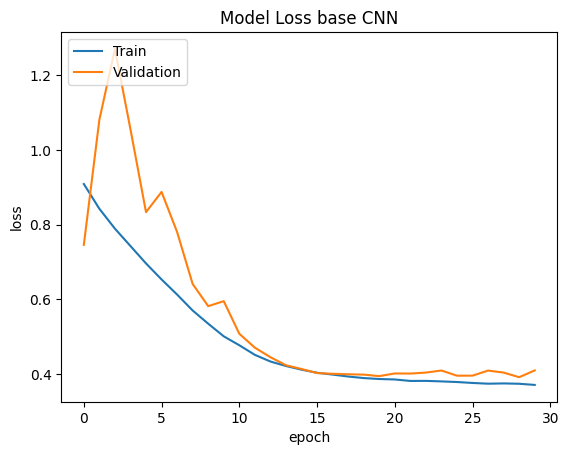

In [43]:
plt.plot(train_cnn.history['loss'])
plt.plot(train_cnn.history['val_loss'])
plt.title("Model Loss base CNN")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['Train','Validation'], loc= 'upper left')
plt.show()

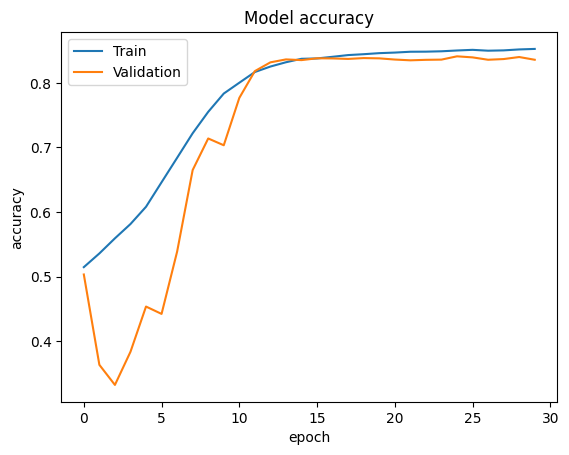

In [44]:
plt.plot(train_cnn.history['binary_accuracy'])
plt.plot(train_cnn.history['val_binary_accuracy'])
plt.title("Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(['Train','Validation'], loc= 'upper left')
plt.show()

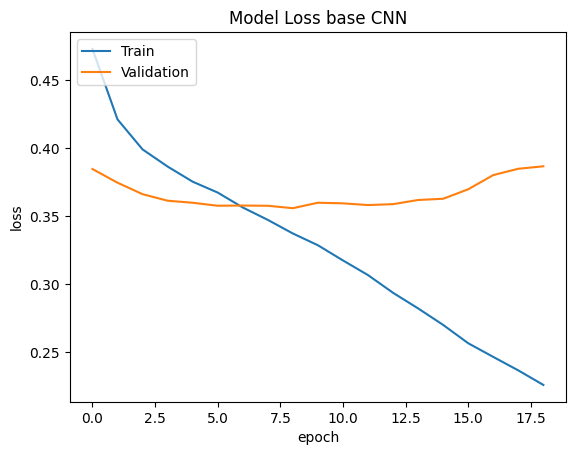

In [45]:
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title("Model Loss base CNN")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['Train','Validation'], loc= 'upper left')
plt.show()

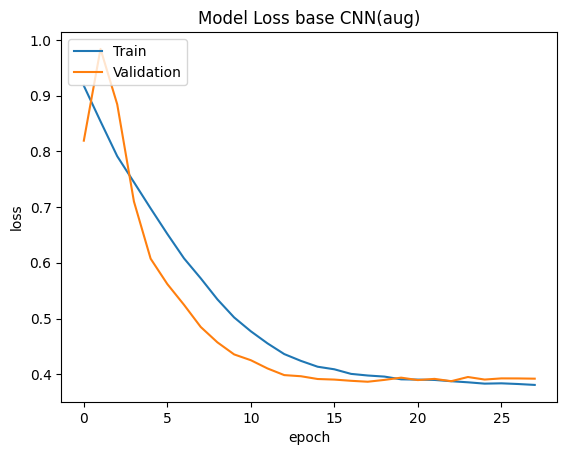

In [46]:
plt.plot(train_aug.history['loss'])
plt.plot(train_aug.history['val_loss'])
plt.title("Model Loss base CNN(aug)")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['Train','Validation'], loc= 'upper left')
plt.show()

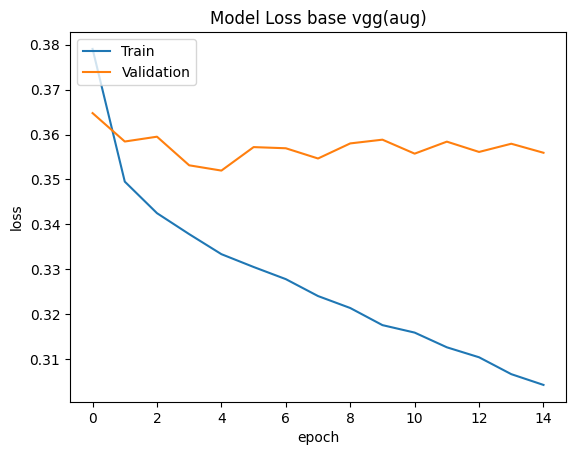

In [47]:
plt.plot(history_aug_vgg.history['loss'])
plt.plot(history_aug_vgg.history['val_loss'])
plt.title("Model Loss base vgg(aug)")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['Train','Validation'], loc= 'upper left')
plt.show()

# Evaluate

In [48]:
model.load_weights('best_model_1_cnn.h5')
model_aug.load_weights('best_model_1_aug.h5')
model_vgg.load_weights('best_vgg.h5')
model_vgg_aug.load_weights('best_vgg_aug.h5')

In [60]:
print("Base cnn test set metrics")
predictions_cnn = model.predict(X_test)
predictions_aug = model_aug.predict(X_test)
predictions_vgg = model_vgg.predict(X_test)
predictions_vgg_aug = model_vgg_aug.predict(X_test)

##Using a threshold to set values from a probability to definitive binary classification
threshold = 0.5
binary_predictions_cnn = np.where(predictions_cnn > threshold, 1, 0)
binary_predictions_aug = np.where(predictions_aug > threshold, 1, 0)
binary_predictions_vgg = np.where(predictions_vgg > threshold, 1, 0)
binary_predictions_vgg_aug = np.where(predictions_vgg_aug > threshold, 1, 0)

loss_cnn, binary_accuracy_cnn = model.evaluate(X_test, y_test)
loss_aug, binary_accuracy_aug = model_aug.evaluate(X_test, y_test)
loss_vgg, binary_accuracy_vgg = model_vgg.evaluate(X_test, y_test)
loss_vgg_aug, binary_accuracy_vgg_aug = model_vgg_aug.evaluate(X_test, y_test)
print(f"CNN Loss: {loss_cnn}, Binary Accuracy: {binary_accuracy_cnn}")
print(f"AUG Loss: {loss_aug}, Binary Accuracy: {binary_accuracy_aug}")
print(f"VGG Loss: {loss_vgg}, Binary Accuracy: {binary_accuracy_vgg}")
print(f"VGG AUG Loss: {loss_vgg_aug}, Binary Accuracy: {binary_accuracy_vgg_aug}")

Base cnn test set metrics
21/21 [==============================] - 1s 36ms/step - loss: 0.3443 - binary_accuracy: 0.8628
CNN Loss: 0.3781791627407074, Binary Accuracy: 0.8476044535636902
AUG Loss: 0.3791556656360626, Binary Accuracy: 0.8470625877380371
VGG Loss: 0.35069385170936584, Binary Accuracy: 0.8558421730995178
VGG AUG Loss: 0.3443000912666321, Binary Accuracy: 0.8627791404724121


In [62]:
report_cnn = classification_report(y_test,binary_predictions_cnn,target_names= unique_genres)
report_aug = classification_report(y_test,binary_predictions_aug,target_names= unique_genres)
report_vgg = classification_report(y_test,binary_predictions_vgg,target_names= unique_genres)
report_vgg_aug = classification_report(y_test,binary_predictions_vgg_aug,target_names= unique_genres)
print("CNN\n")
print(f"{report_cnn}\n")

print("AUG\n")
print(f"{report_aug}\n")

print("VGG\n")
print(f"{report_vgg}\n")

print("VGG_AUG\n")
print(f"{report_vgg_aug}\n")


CNN

              precision    recall  f1-score   support

      action       0.00      0.00      0.00       139
   adventure       0.00      0.00      0.00        70
   biography       0.00      0.00      0.00        28
      comedy       0.74      0.27      0.40       291
       crime       0.00      0.00      0.00       127
 documentary       0.00      0.00      0.00        45
       drama       0.54      0.79      0.64       338
      family       0.00      0.00      0.00        31
     fantasy       0.00      0.00      0.00        50
      horror       0.00      0.00      0.00        57
     mystery       0.00      0.00      0.00        55
     romance       0.00      0.00      0.00       131
      sci-fi       0.00      0.00      0.00        38
    thriller       0.00      0.00      0.00        99

   micro avg       0.58      0.23      0.33      1499
   macro avg       0.09      0.08      0.07      1499
weighted avg       0.27      0.23      0.22      1499
 samples avg       0.

C:\Program Files\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Program Files\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Program Files\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Program Files\Python310\lib\sit

In [115]:
def evaluate_model_AUC(predictions, model_name, y_test, unique_genres):
    average_precisions = {}
    for i, genre in enumerate(unique_genres):
        if np.sum(y_test[:, i]) == 0:
            average_precisions[genre] = None
            continue
        average_precisions[genre] = average_precision_score(y_test[:, i], predictions[:, i])

    # Output the average precision scores
    print(f"Model: {model_name}")
    for genre, avg_prec in sorted(average_precisions.items(), key=lambda x: x[1] if x[1] is not None else -1, reverse=True):
        if avg_prec is not None:
            print(f"{genre}: AUC-PR = {avg_prec:.4f}")
        else:
            print(f"{genre}: AUC-PR = Not Calculable - No Positive Samples")

    # Plot Precision-Recall curve for each genre
    fig, ax = plt.subplots(figsize=(12, 8))
    for i, genre in enumerate(unique_genres):
        if average_precisions[genre] is not None:
            precision, recall, _ = precision_recall_curve(y_test[:, i], predictions[:, i])
            ax.plot(recall, precision, label=f'{genre} (AUC-PR = {average_precisions[genre]:.4f})')

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall Curve per Genre for {model_name}')
    ax.legend(loc='best', fontsize='small')
    plt.show()

Model: CNN Model
comedy: AUC-PR = 0.6805
drama: AUC-PR = 0.6002
romance: AUC-PR = 0.2924
horror: AUC-PR = 0.2708
thriller: AUC-PR = 0.2697
action: AUC-PR = 0.2601
crime: AUC-PR = 0.2473
adventure: AUC-PR = 0.1428
mystery: AUC-PR = 0.1358
fantasy: AUC-PR = 0.1062
biography: AUC-PR = 0.1033
sci-fi: AUC-PR = 0.1026
family: AUC-PR = 0.0865
documentary: AUC-PR = 0.0706


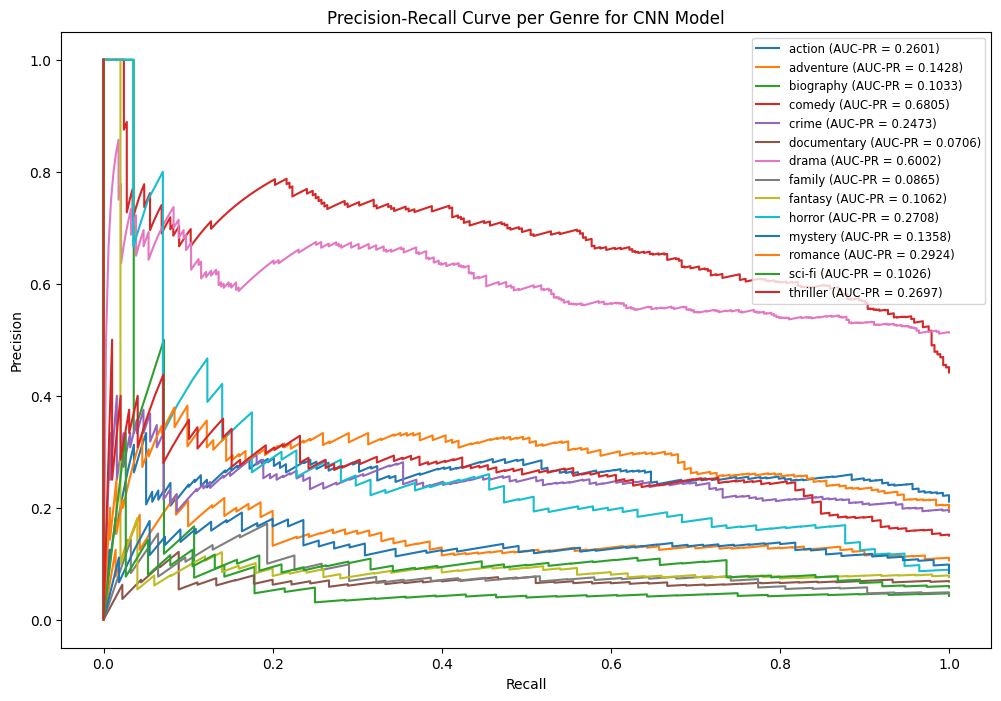

Model: Augmented Model
comedy: AUC-PR = 0.6956
drama: AUC-PR = 0.5777
horror: AUC-PR = 0.2759
romance: AUC-PR = 0.2712
action: AUC-PR = 0.2637
thriller: AUC-PR = 0.2550
crime: AUC-PR = 0.2144
mystery: AUC-PR = 0.1352
fantasy: AUC-PR = 0.1341
adventure: AUC-PR = 0.1251
documentary: AUC-PR = 0.0798
family: AUC-PR = 0.0640
sci-fi: AUC-PR = 0.0586
biography: AUC-PR = 0.0437


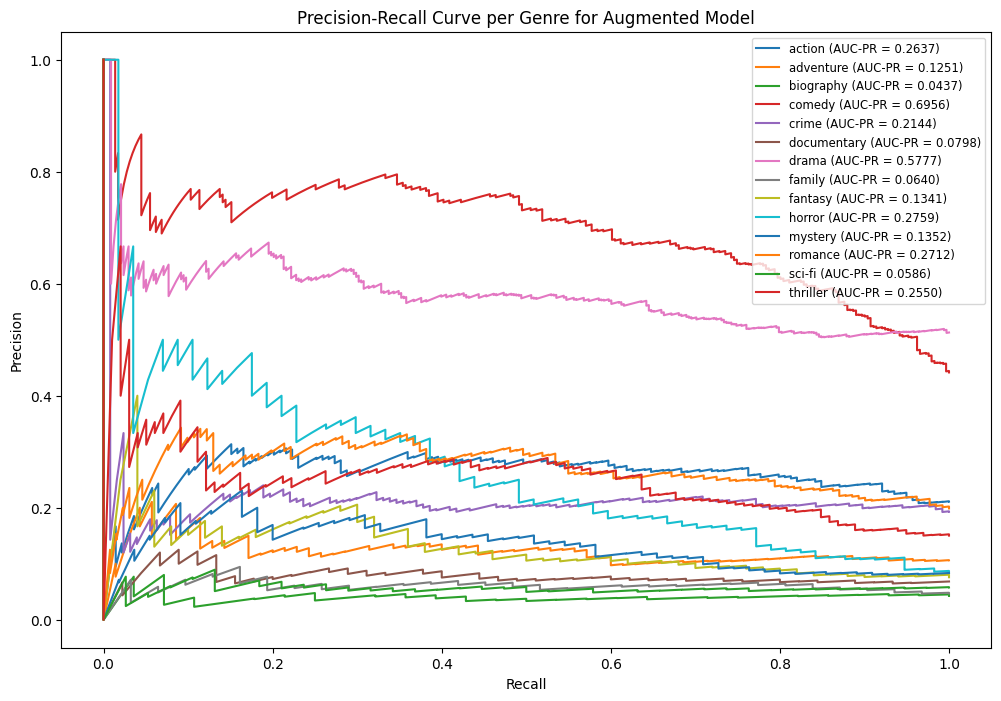

Model: VGG Model
comedy: AUC-PR = 0.7961
drama: AUC-PR = 0.6809
action: AUC-PR = 0.4037
romance: AUC-PR = 0.3313
horror: AUC-PR = 0.3238
thriller: AUC-PR = 0.3077
crime: AUC-PR = 0.2751
adventure: AUC-PR = 0.2507
sci-fi: AUC-PR = 0.2016
mystery: AUC-PR = 0.1501
documentary: AUC-PR = 0.1255
fantasy: AUC-PR = 0.1168
family: AUC-PR = 0.0634
biography: AUC-PR = 0.0507


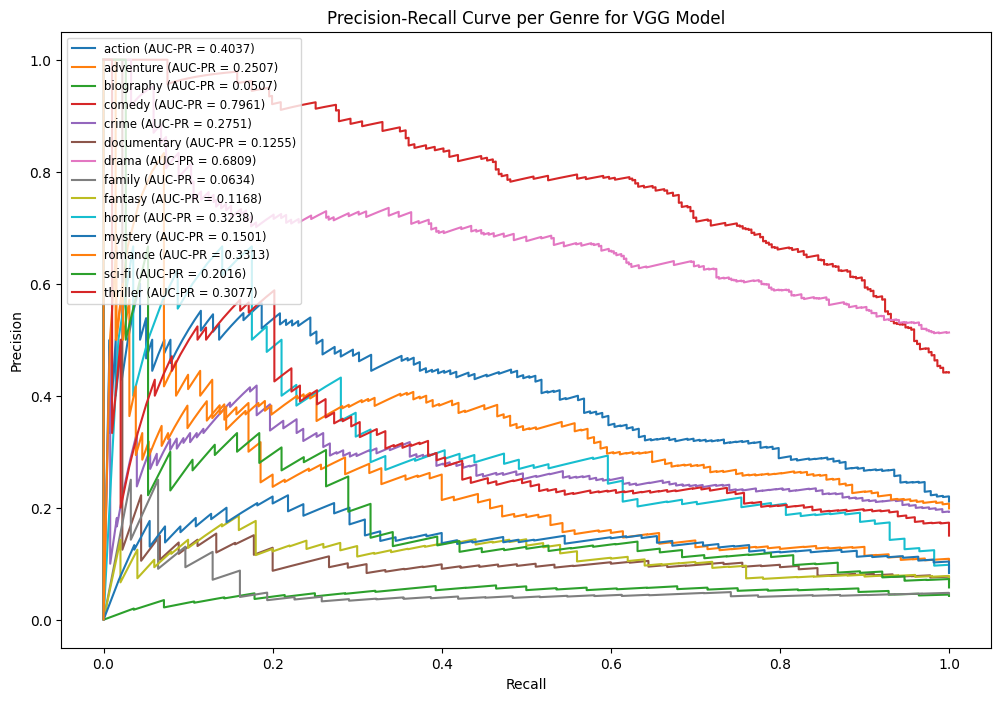

Model: VGG Augmented Model
comedy: AUC-PR = 0.8138
drama: AUC-PR = 0.6828
action: AUC-PR = 0.4146
romance: AUC-PR = 0.3855
crime: AUC-PR = 0.3389
horror: AUC-PR = 0.3254
thriller: AUC-PR = 0.3031
family: AUC-PR = 0.2706
adventure: AUC-PR = 0.2607
mystery: AUC-PR = 0.1968
sci-fi: AUC-PR = 0.1936
documentary: AUC-PR = 0.1679
fantasy: AUC-PR = 0.1565
biography: AUC-PR = 0.0736


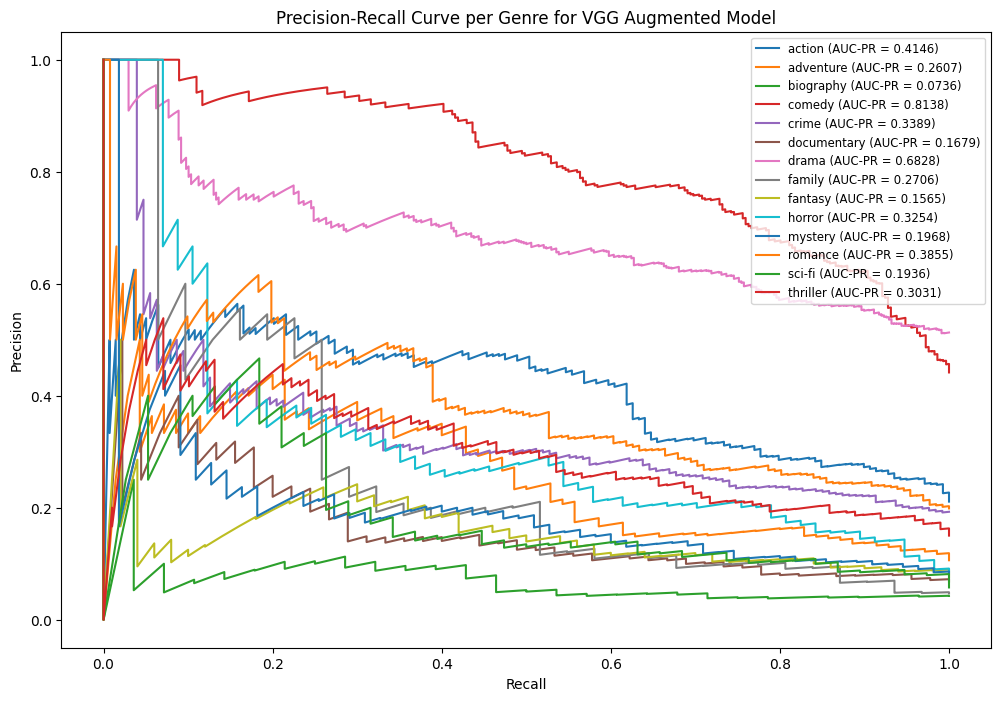

In [116]:
evaluate_model_AUC(predictions_cnn, "CNN Model", y_test, unique_genres)
evaluate_model_AUC(predictions_aug, "Augmented Model", y_test, unique_genres)
evaluate_model_AUC(predictions_vgg, "VGG Model", y_test, unique_genres)
evaluate_model_AUC(predictions_vgg_aug, "VGG Augmented Model", y_test, unique_genres)

In [67]:
confusion_cnn = multilabel_confusion_matrix(y_test,binary_predictions_cnn)
print("CNN\n")
print(confusion_cnn)

confusion_aug = multilabel_confusion_matrix(y_test,binary_predictions_aug)
print("AUG\n")
print(confusion_aug)

confusion_vgg = multilabel_confusion_matrix(y_test,binary_predictions_vgg)
print("VGG\n")
print(confusion_vgg)

confusion_vgg_aug = multilabel_confusion_matrix(y_test,binary_predictions_vgg_aug)
print("VGG_AUG\n")
print(confusion_vgg_aug)

confusion_matrices = [confusion_cnn,confusion_aug,confusion_vgg,confusion_vgg_aug]

CNN

[[[520   0]
  [139   0]]

 [[589   0]
  [ 70   0]]

 [[631   0]
  [ 28   0]]

 [[340  28]
  [212  79]]

 [[532   0]
  [127   0]]

 [[614   0]
  [ 45   0]]

 [[ 95 226]
  [ 70 268]]

 [[628   0]
  [ 31   0]]

 [[609   0]
  [ 50   0]]

 [[602   0]
  [ 57   0]]

 [[604   0]
  [ 55   0]]

 [[528   0]
  [131   0]]

 [[621   0]
  [ 38   0]]

 [[560   0]
  [ 99   0]]]
AUG

[[[520   0]
  [139   0]]

 [[589   0]
  [ 70   0]]

 [[631   0]
  [ 28   0]]

 [[329  39]
  [176 115]]

 [[532   0]
  [127   0]]

 [[614   0]
  [ 45   0]]

 [[ 57 264]
  [ 62 276]]

 [[628   0]
  [ 31   0]]

 [[609   0]
  [ 50   0]]

 [[602   0]
  [ 57   0]]

 [[604   0]
  [ 55   0]]

 [[528   0]
  [131   0]]

 [[621   0]
  [ 38   0]]

 [[560   0]
  [ 99   0]]]
VGG

[[[520   0]
  [139   0]]

 [[589   0]
  [ 70   0]]

 [[631   0]
  [ 28   0]]

 [[329  39]
  [147 144]]

 [[532   0]
  [127   0]]

 [[614   0]
  [ 45   0]]

 [[283  38]
  [236 102]]

 [[628   0]
  [ 31   0]]

 [[609   0]
  [ 50   0]]

 [[602   0]
  [ 57   0]

In [78]:
def plot_multilabel_confusion_matrices(conf_matrices, labels, figsize=(20, 15)):
    num_labels = len(labels)
    # Determine the grid size you'll need
    cols = int(np.ceil(np.sqrt(num_labels)))
    rows = int(np.ceil(num_labels / cols))
    
    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()  # Flatten to make it easier to iterate over

    # Loop through the labels and plot each confusion matrix
    for i in range(len(labels)):
        ax = axes[i]
        # Plot the heatmap
        sns.heatmap(conf_matrices[i], annot=True, fmt='d', cmap='Reds', ax=ax,
                    xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
        ax.set_title(f'Confusion Matrix for {labels[i]}')
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')

    # Hide any unused axes
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

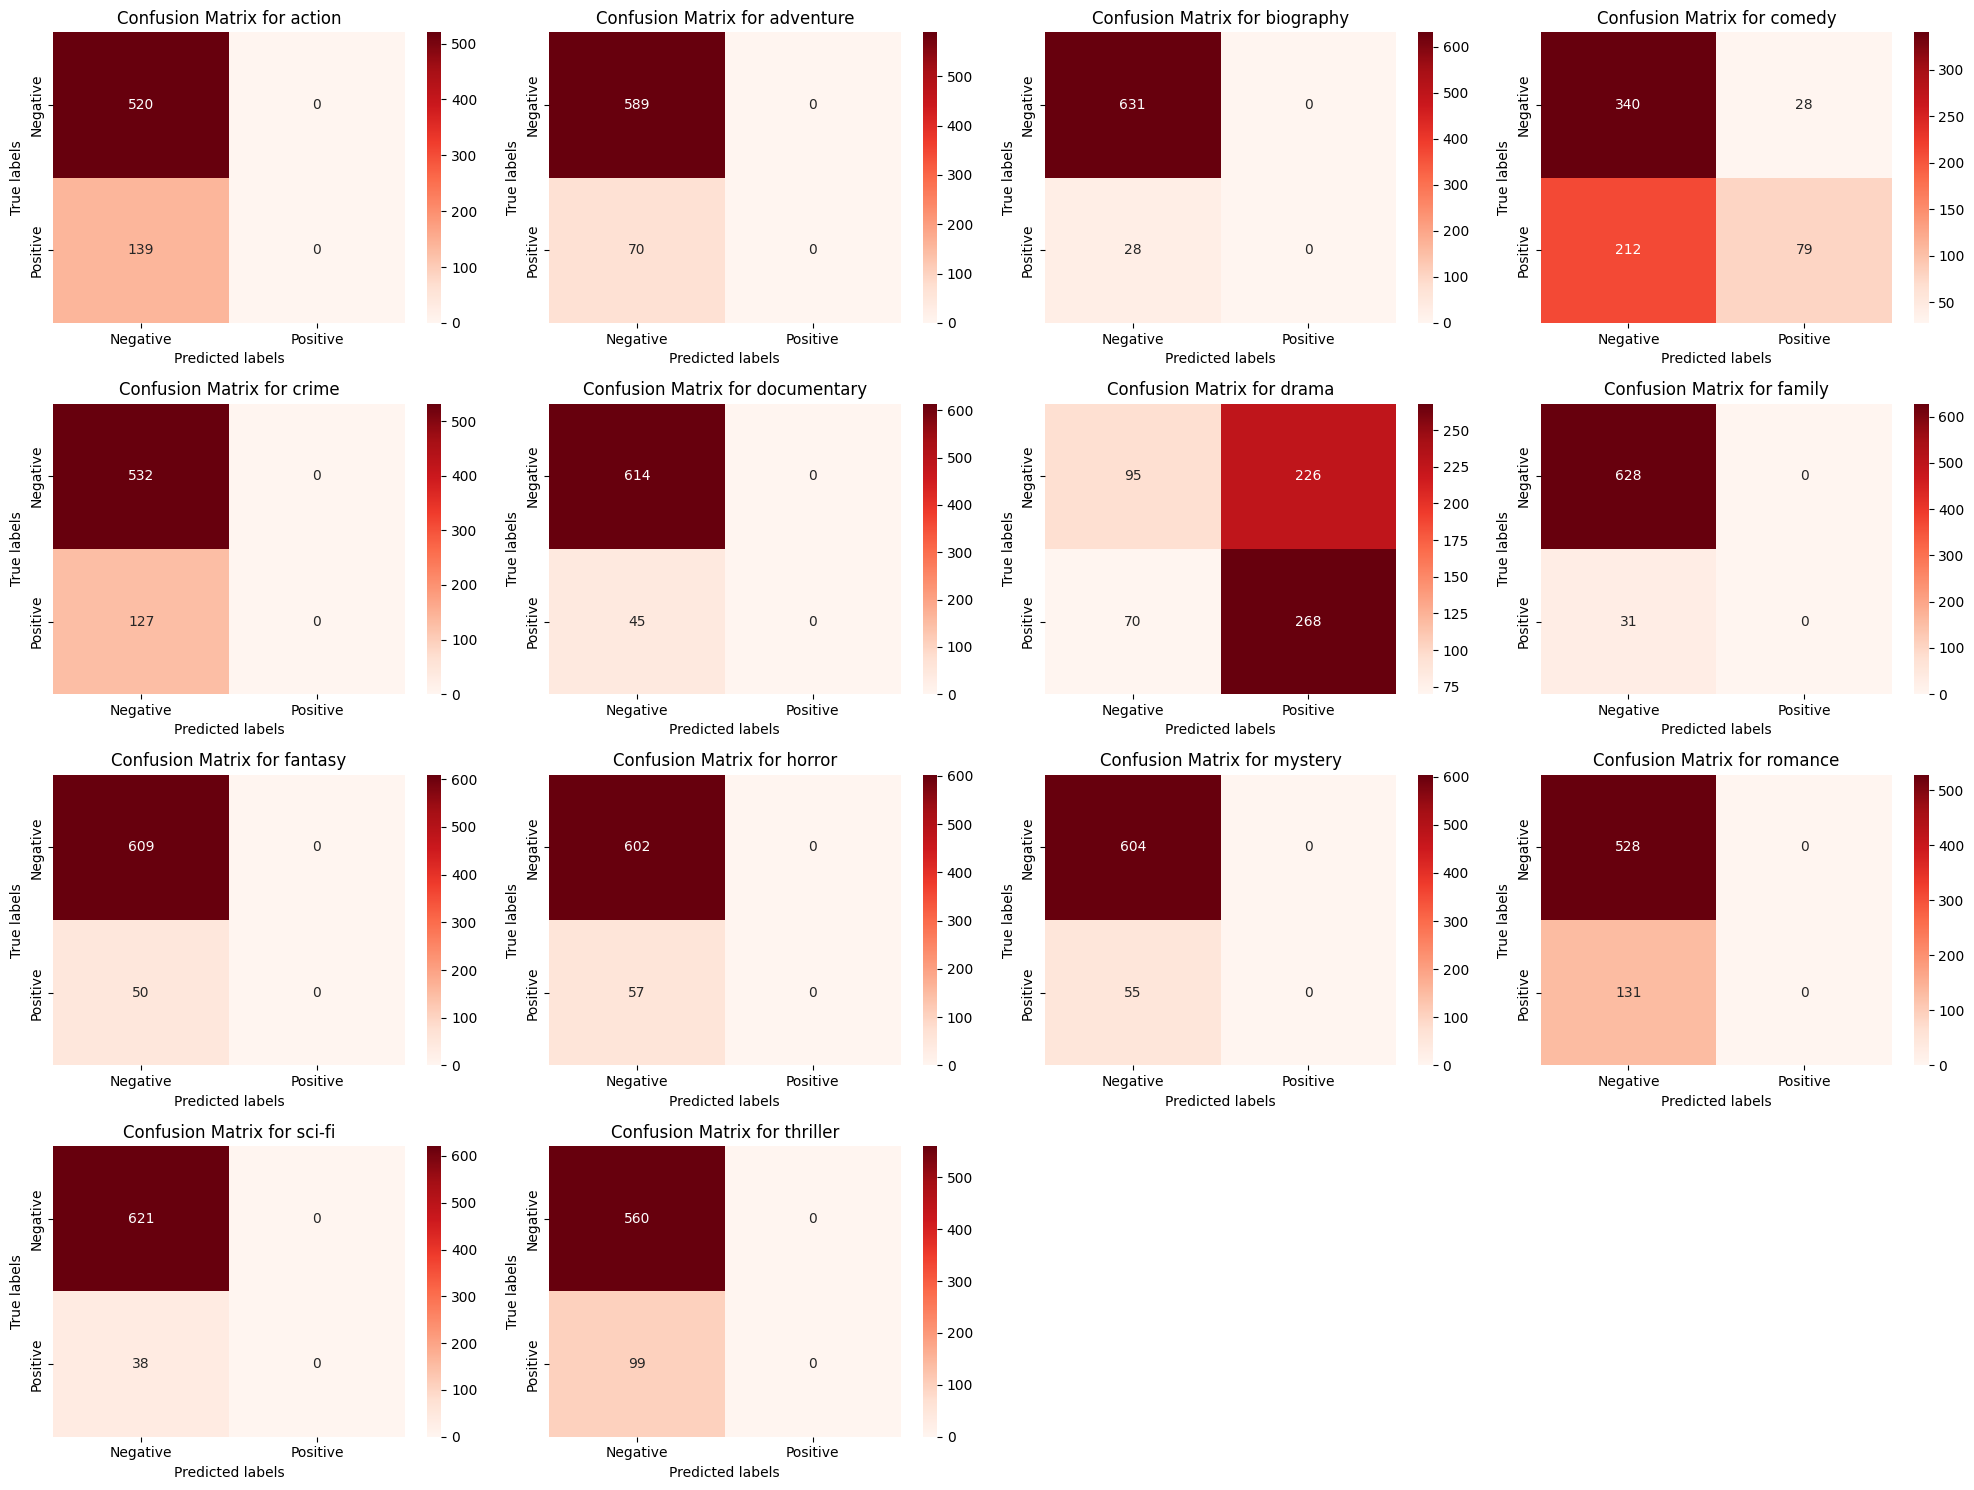

In [79]:
plot_multilabel_confusion_matrices(confusion_cnn, unique_genres)

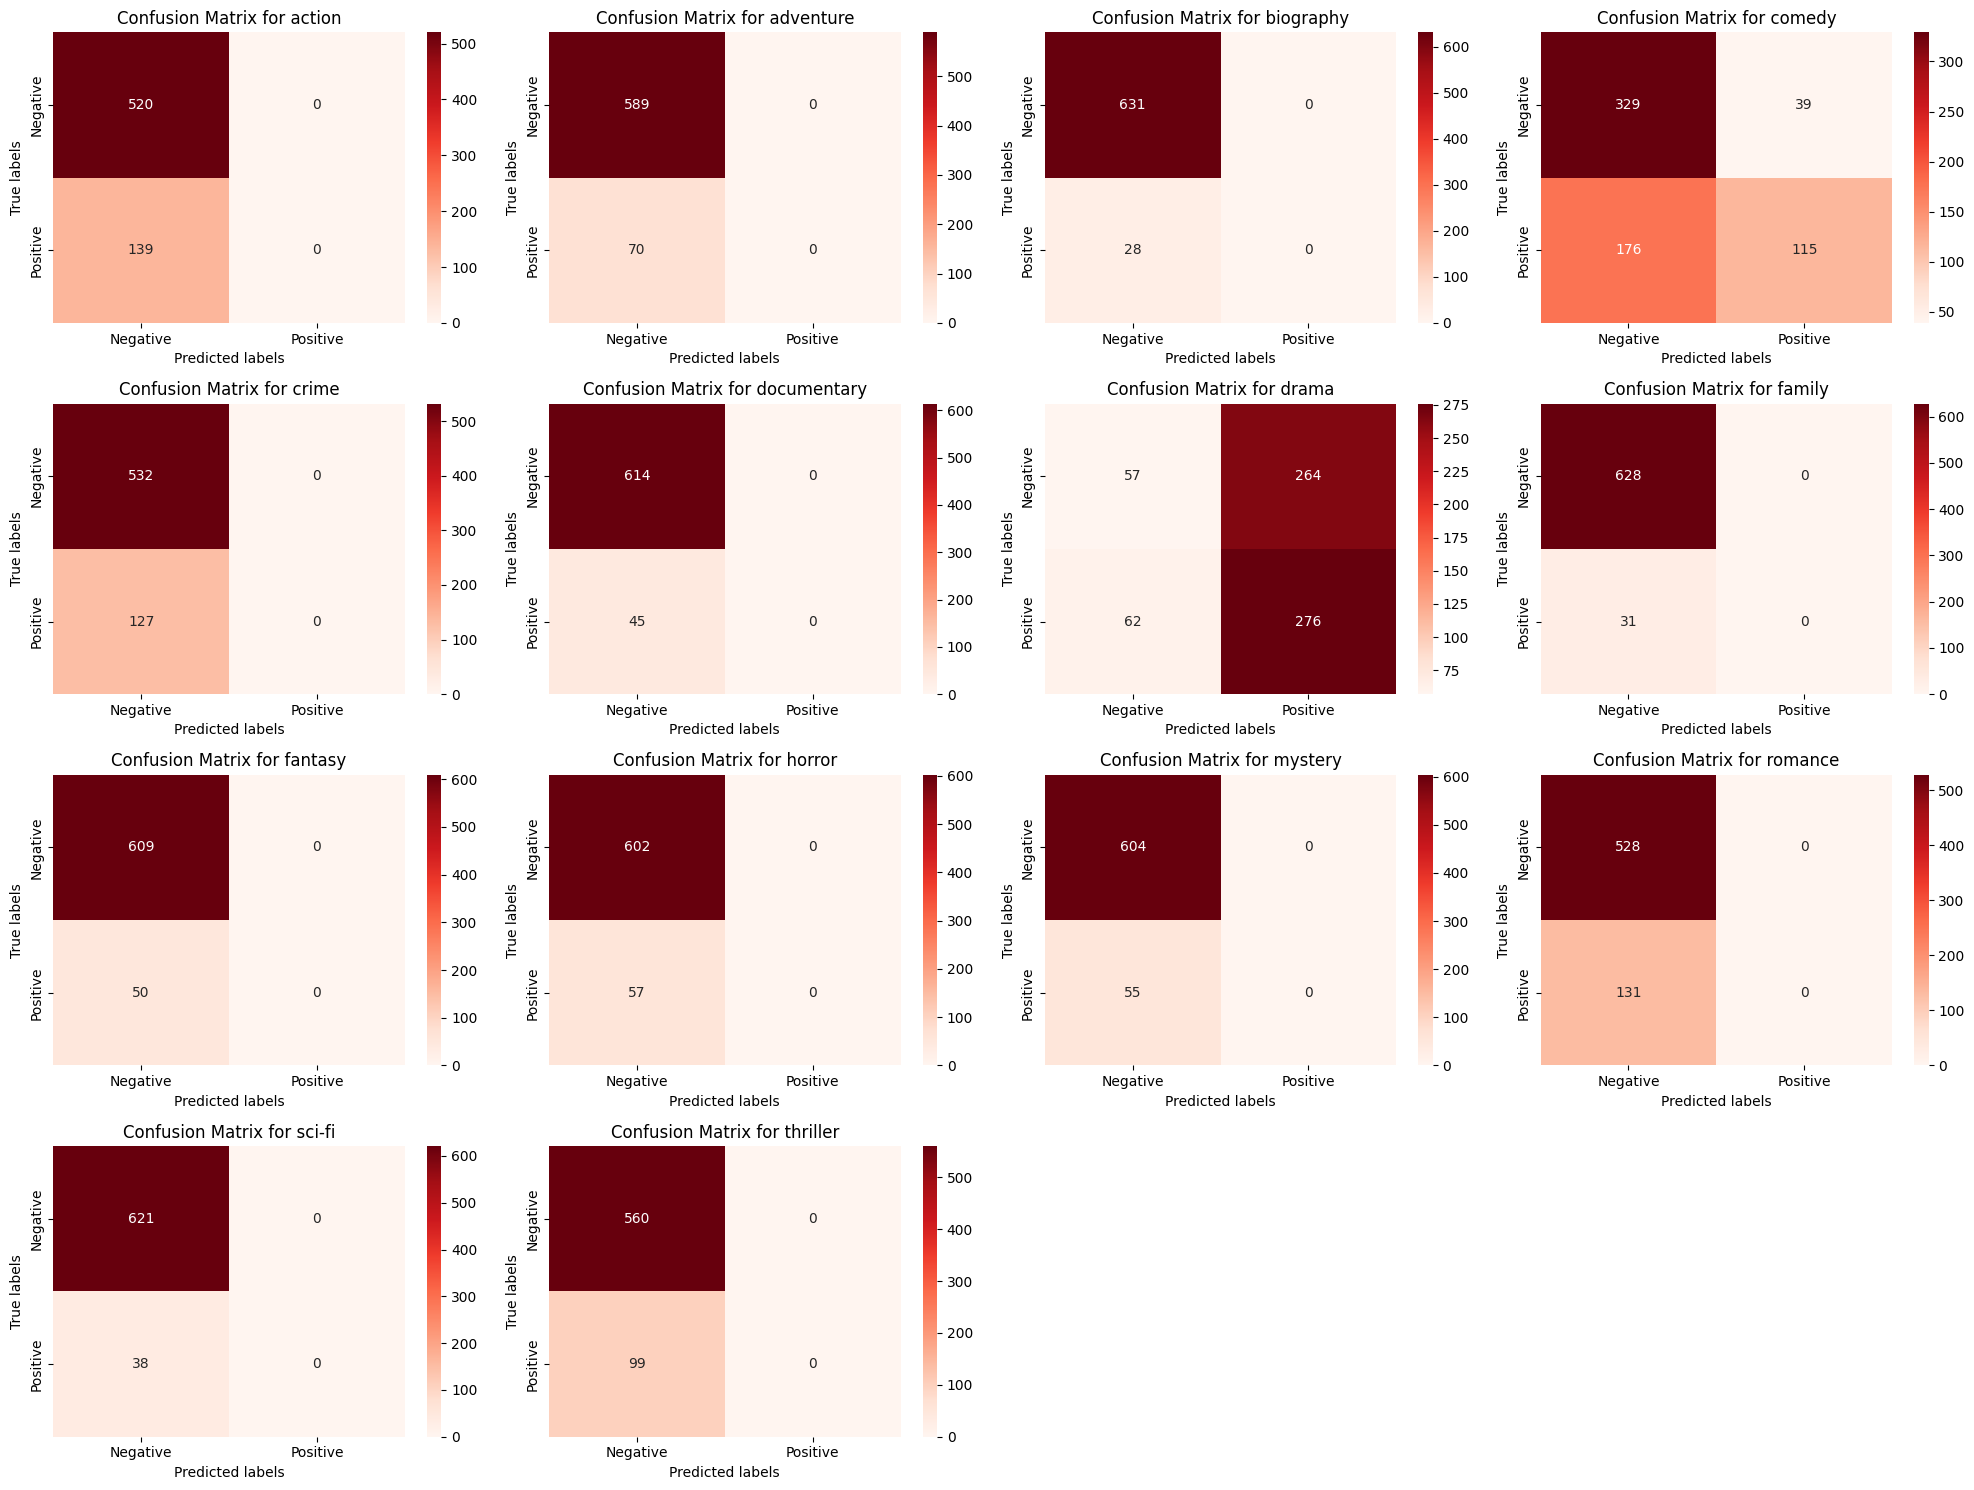

In [80]:
plot_multilabel_confusion_matrices(confusion_aug, unique_genres)

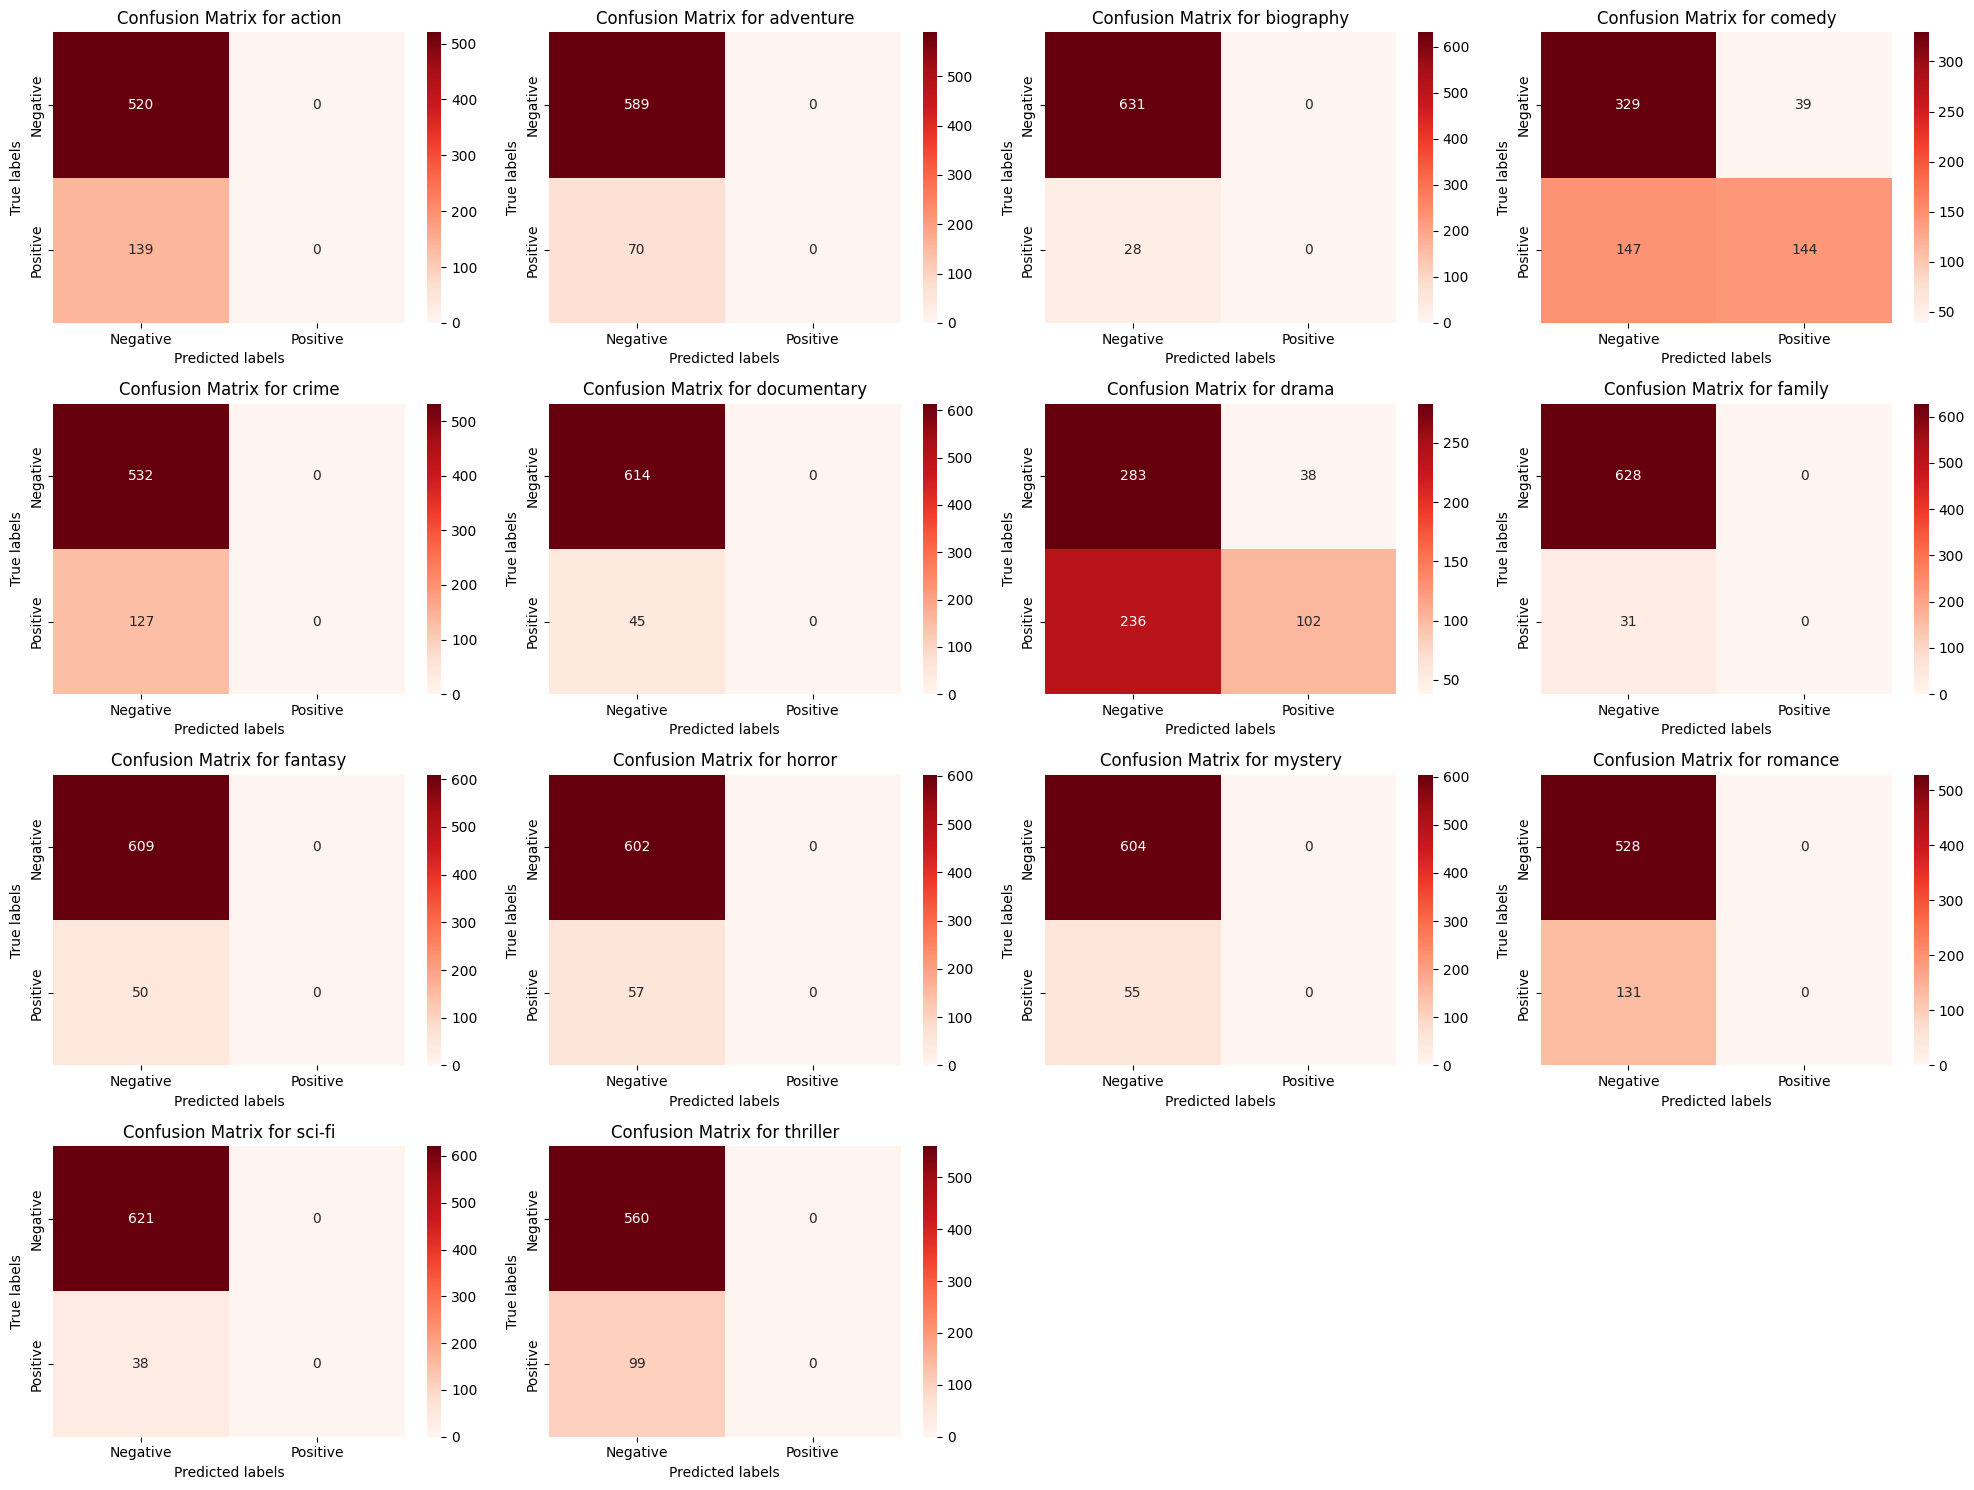

In [81]:
plot_multilabel_confusion_matrices(confusion_vgg, unique_genres)

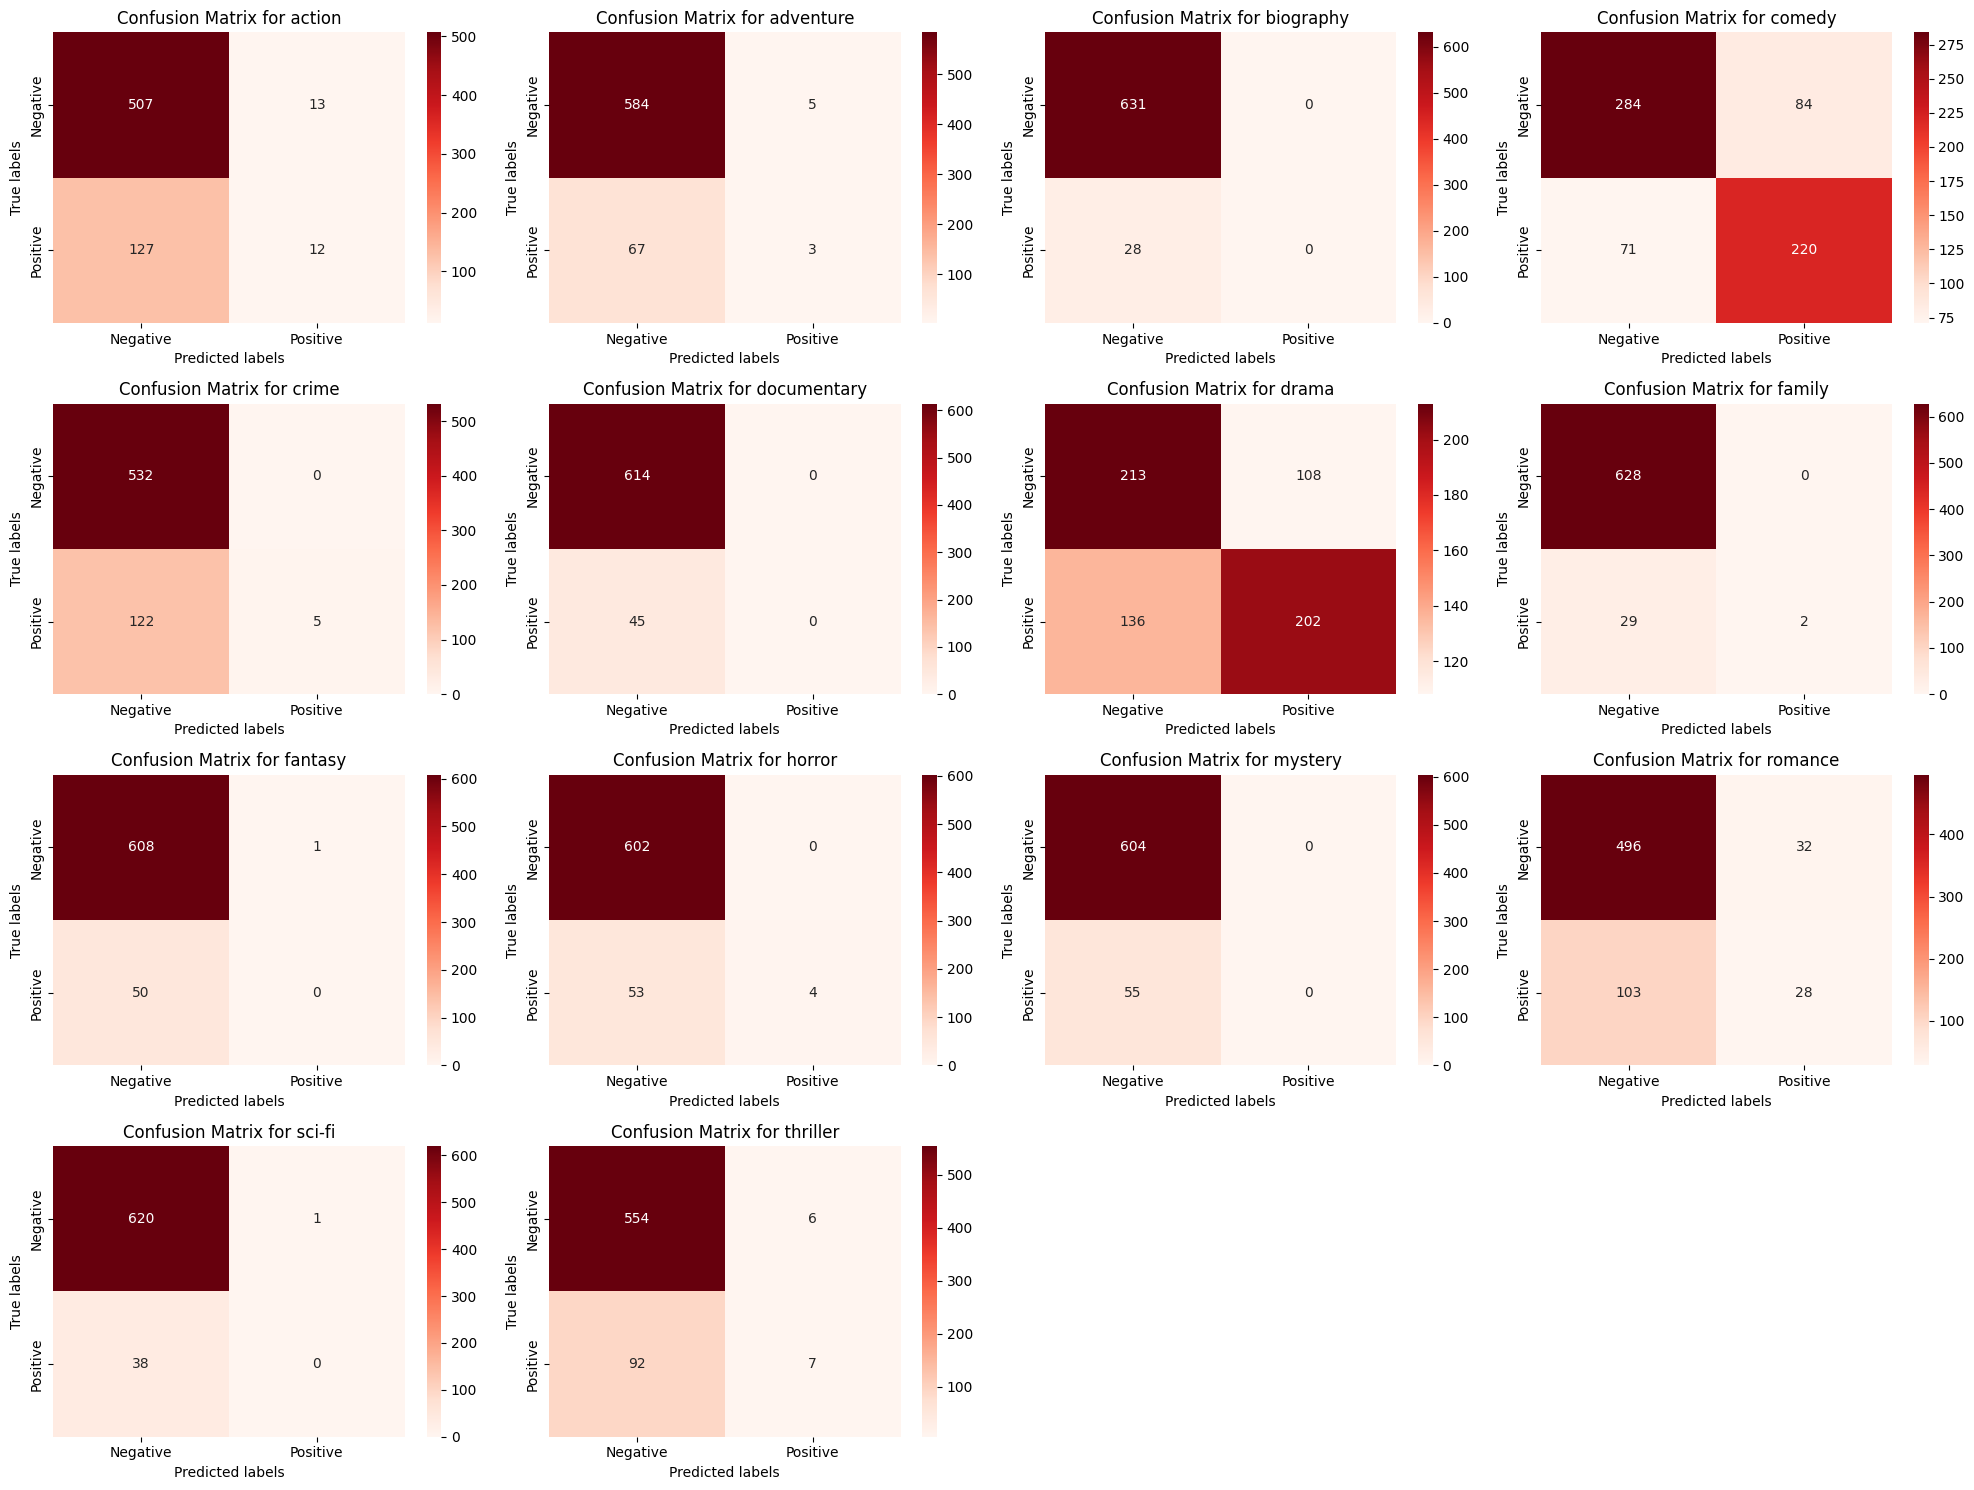

In [82]:
plot_multilabel_confusion_matrices(confusion_vgg_aug, unique_genres)

In [256]:
# Load the image with the correct target size as per your model's input layer
Beekeeperimg = image.load_img(r"C:\Users\david\DeepLearning\DataSets\Movie_Poster_Dataset\NewMovies\BeeKeeper.jpeg", target_size=(112, 112))
Duneimg = image.load_img(r"C:\Users\david\DeepLearning\DataSets\Movie_Poster_Dataset\NewMovies\Dune.jpg", target_size=(112, 112))
Insidiousimg = image.load_img(r"C:\Users\david\DeepLearning\DataSets\Movie_Poster_Dataset\NewMovies\Insidious.jpeg", target_size=(112, 112))

img_arrayb = image.img_to_array(Beekeeperimg)
img_arrayd = image.img_to_array(Duneimg)
img_arrayi = image.img_to_array(Insidiousimg)


# Normalize the image data
img_arrayb = img_arrayb / 255.0
img_arrayd = img_arrayd / 255.0
img_arrayi = img_arrayi / 255.0
# Reshape the image data for the model (adding batch dimension)
img_arrayb = np.expand_dims(img_arrayb, axis=0)
img_arrayd = np.expand_dims(img_arrayd, axis=0)
img_arrayi = np.expand_dims(img_arrayi, axis=0)

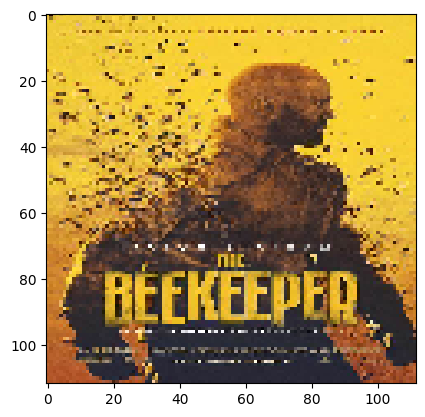

In [260]:
plt.imshow(Beekeeperimg)

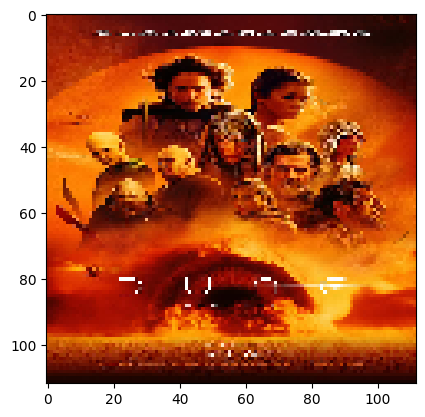

In [261]:
plt.imshow(Duneimg)

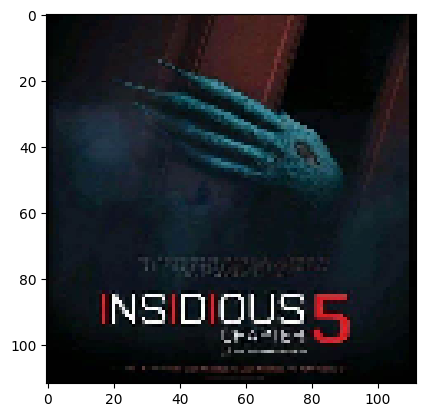

In [262]:
plt.imshow(Insidiousimg)

In [263]:
# Predict the genres
predictionsb_cnn = model.predict(img_arrayb)
predictionsd_cnn = model.predict(img_arrayd)
predictionsi_cnn = model.predict(img_arrayi)

predictionsb_aug = model_aug.predict(img_arrayb)
predictionsd_aug = model_aug.predict(img_arrayd)
predictionsi_aug = model_aug.predict(img_arrayi)

predictionsb_vgg = model_vgg.predict(img_arrayb)
predictionsd_vgg = model_vgg.predict(img_arrayd)
predictionsi_vgg = model_vgg.predict(img_arrayi)

predictionsb_vgg_aug = model_vgg_aug.predict(img_arrayb)
predictionsd_vgg_aug = model_vgg_aug.predict(img_arrayd)
predictionsi_vgg_aug = model_vgg_aug.predict(img_arrayi)

# Assuming 'unique_genres' is an array of genre labels corresponding to the output of the model
# Assuming your model outputs probabilities and you're using a threshold of 0.5
predicted_genresb_cnn = [unique_genres[i] for i in range(len(unique_genres)) if predictionsb_cnn[0, i] > 0.5]
predicted_genresd_cnn = [unique_genres[i] for i in range(len(unique_genres)) if predictionsd_cnn[0, i] > 0.5]
predicted_genresi_cnn = [unique_genres[i] for i in range(len(unique_genres)) if predictionsi_cnn[0, i] > 0.5]

predicted_genresb_aug = [unique_genres[i] for i in range(len(unique_genres)) if predictionsb_aug[0, i] > 0.5]
predicted_genresd_aug = [unique_genres[i] for i in range(len(unique_genres)) if predictionsd_aug[0, i] > 0.5]
predicted_genresi_aug = [unique_genres[i] for i in range(len(unique_genres)) if predictionsi_aug[0, i] > 0.5]

predicted_genresb_vgg = [unique_genres[i] for i in range(len(unique_genres)) if predictionsb_vgg [0, i] > 0.5]
predicted_genresd_vgg = [unique_genres[i] for i in range(len(unique_genres)) if predictionsd_vgg [0, i] > 0.5]
predicted_genresi_vgg = [unique_genres[i] for i in range(len(unique_genres)) if predictionsi_vgg [0, i] > 0.5]

predicted_genresb_vgg_aug = [unique_genres[i] for i in range(len(unique_genres)) if predictionsb_vgg_aug[0, i] > 0.5]
predicted_genresd_vgg_aug = [unique_genres[i] for i in range(len(unique_genres)) if predictionsd_vgg_aug[0, i] > 0.5]
predicted_genresi_vgg_aug = [unique_genres[i] for i in range(len(unique_genres)) if predictionsi_vgg_aug[0, i] > 0.5]

print("Bee cnnPredicted genres:", predicted_genresb_cnn)
print("Dune cnnPredicted genres:", predicted_genresd_cnn)
print("Insidious cnnPredicted genres:", predicted_genresi_cnn)

print("Bee augPredicted genres:", predicted_genresb_aug)
print("Dune augPredicted genres:", predicted_genresd_aug)
print("Insidious augPredicted genres:", predicted_genresi_aug)

print("Bee vggPredicted genres:", predicted_genresb_vgg)
print("Dune vggPredicted genres:", predicted_genresd_vgg)
print("Insidious vggPredicted genres:", predicted_genresi_vgg)

print("Bee vgg_augPredicted genres:", predicted_genresb_vgg_aug)
print("Dune vgg_augPredicted genres:", predicted_genresd_vgg_aug)
print("Insidious vgg_augPredicted genres:", predicted_genresi_vgg_aug)




1/1 [==============================] - 0s 21ms/step
Bee cnnPredicted genres: ['drama']
Dune cnnPredicted genres: []
Insidious cnnPredicted genres: ['drama']
Bee augPredicted genres: ['drama']
Dune augPredicted genres: []
Insidious augPredicted genres: ['drama']
Bee vggPredicted genres: ['drama']
Dune vggPredicted genres: []
Insidious vggPredicted genres: []
Bee vgg_augPredicted genres: ['drama']
Dune vgg_augPredicted genres: ['comedy']
Insidious vgg_augPredicted genres: ['drama']
